In [1]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import re
from pandas import DataFrame
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import numpy as np
import scipy as sp
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import _pickle as pkl
import sys
sys.setrecursionlimit(10000)

#nltk.download('stopwords')
stop = stopwords.words('english')

def preprocessor(text):
    # remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)
    
    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text


def tokenizer_stem(text):
    porter = PorterStemmer()
    return [porter.stem(word) for word in re.split('\s+', text.strip())]

def tokenizer_by_tense(sentence):
    tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    important_words = []
    for t in tagged:
        tag_name = t[1][0:2]
        word = t[0].lower()
        if tag_name=='NN' or tag_name=='JJ' or tag_name=='VB' or tag_name=='RB':
            porter = PorterStemmer()
            important_words.append(word)
        
    return [porter.stem(w) for w in important_words if w not in stop and re.match('[a-zA-Z]+', w)]

def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split('\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

df_train = pd.read_csv('datasets/train.csv')
df_test = pd.read_csv('datasets/test.csv')
sample_submission = pd.read_csv('datasets/sample_submission.csv')
#print(df_train.head(5))
#print(df_test.head(5))
page0 = df_train.loc[0,'Page content']
page1 = df_train.loc[1,'Page content']
#print(page0)
df_small = df_train.sample(n=10,random_state=0)
#print(df_small.iloc[0]['Page content'])
DF_train = pkl.load(open('outputs/df_train.pkl', 'rb'))
DF_test = pkl.load(open('outputs/df_test.pkl', 'rb'))
DF_train_combined = pkl.load(open('outputs/df_train_combined','rb'))
DF_test_combined = pkl.load(open('outputs/df_test_combined','rb'))
DF_train_combined2 = pkl.load(open('outputs/df_train_combined2','rb'))
DF_test_combined2 = pkl.load(open('outputs/df_test_combined2','rb'))
DF_train_combined3 = pkl.load(open('outputs/df_train_combined3','rb'))
DF_test_combined3 = pkl.load(open('outputs/df_test_combined3','rb'))
DF_train_combined4 = pkl.load(open('outputs/df_train_combined4','rb'))
DF_test_combined4 = pkl.load(open('outputs/df_test_combined4','rb'))

CPU times: user 6.14 s, sys: 1.36 s, total: 7.5 s
Wall time: 17.8 s


In [2]:
# Parse datetime from html
from dateutil import parser

# Extract features from raw HTML
# Usage: 
# page0 = df.loc[0,'Page content']
# extract_feature(page0)
def extract_feature(html):
    
    bs = BeautifulSoup(html, 'html.parser')
    
    # link
    link_count = len(bs.findAll('a', href=True)) 
    
    # image
    img_count = len(bs.findAll('img'))
    
    # animation, chart or video
    iframe_count = len(bs.findAll('iframe'))
    
    # quote
    quote_count = len(bs.findAll('blockquote'))
    
    # tags
    tags = [] 
    for tag in bs.select('footer a'):
        tags.append(tag.string)
        
    # category
    category = ""
    for cat in bs.findAll('article'):
        try:
            category = cat['data-channel']
            break
        except:
            category = ""
            continue
            
    # author (seem not notable) -> discard(?)
    '''
    author_raw = bs.find("div", { "class" : "article-info" })
    try:
        author = author_raw.find('a')['href']
    except:
        pass
    
    try:
        author = author_raw.find('span',{'class':'author_name'}).string
    except:
        pass
    '''
    
    # title info. (h1) (must be helpful)
    title = bs.find("h1", { "class" : "title" }).string
    title_words_count = len(re.split(r'\s+', title))
    title_digits_count = len([int(s) for s in title.split() if s.isdigit()])
    title_question_mark = ('?' in title) # boolean
    title_exclamation_mark = ('!' in title) # boolean
    
    # sub-title (h2) (must be helpful)
    # count how many sub-title in the article
    try:
        h2 = bs.find('h2')
        sub_title_count = len(bs.find('h2'))
    except:
        sub_title_count = 0
    
    # get word set
    pre_text = preprocessor(html)
    tokens = tokenizer_by_tense(pre_text)
    total_word_count = len(tokens)
    
    # date
    try:
        datetime = bs.time['datetime']
        l = re.split(r'\s+', datetime)
        weekday = re.sub(',','',l[0])
        day = l[1]
        month = l[2]
        year = l[3]
        time = l[4]
        
        if year == 'Jan':
            m = 1
        elif year == 'Feb':
            m = 2
        elif year == 'Mar':
            m = 3
        elif year == 'Apr':
            m = 4
        elif year == 'May':
            m = 5
        elif year == 'Jun':
            m = 6
        elif year == 'Jul':
            m = 7
        elif year == 'Aug':
            m = 8
        elif year == 'Sep':
            m = 9
        elif year == 'Oct':
            m = 10
        elif year == 'Nov':
            m = 11
        else:
            m = 12
        
        #howlong = (int(year) - 2013)*365 #+ (int(month) - 1)*30 + int(day)
        howlong = (int(year)-2013)*365 + (m-1)*30 + int(day)
        
        t = int(time.split(':')[0]) # 
        if t in [0,3]: 
            time_interval = 1 # 0~3
        elif t in [4,7]: 
            time_interval = 2 # 4~7
        elif t in [8,11]: 
            time_interval = 3 # 8~11
        elif t in [12,15]:
            time_interval = 4 # 12~15 
        elif t in [16,19]:
            time_interval = 5 # 16~19
        else: 
            time_interval = 6 # 20~23

    except:
        weekday = 'Mon'
        day = 0
        month = 'Jun'
        year = '2013'
        time = 0
        howlong = 0
        time_interval = 1
    
    # return 
    tmp = []
    tmp.append(link_count)
    tmp.append(img_count)
    tmp.append(iframe_count)
    tmp.append(quote_count)
    tmp.append(tags)
    tmp.append(category)
    #tmp.append(author)
    tmp.append(total_word_count)
    
    #tmp.append(parsed_date)
    tmp.append(weekday)
    tmp.append(day)
    tmp.append(month)
    tmp.append(year)
    tmp.append(time)
    tmp.append(howlong)
    tmp.append(time_interval)
    
    tmp.append(title_words_count)
    tmp.append(title_digits_count)
    tmp.append(sub_title_count)
    tmp.append(title_question_mark)
    
    
    return tmp

In [80]:
%%time 
# about 25min for df_train
# about 11min for df_test
dd = df_test
dsize = dd.shape[0] #df_train.shape[0] #df_small.shape[0] 
link_count=[]
img_count=[]
iframe_count=[]
quote_count=[]
tags=[]
categories=[]
authors=[]
total_word_count=[]
#parsed_date=[]
weekday=[]
day=[]
month=[]
year=[]
time=[]
howlong=[]
time_interval=[]
title_words_count=[]
title_digits_count=[]
title_question_mark=[]
sub_title_count=[]

for i in range(dsize):
    features = extract_feature(dd.iloc[i]['Page content'])
    link_count.append(features[0])
    img_count.append(features[1])
    iframe_count.append(features[2])
    quote_count.append(features[3])
    tags.append(features[4])
    categories.append(features[5])
    #authors.append(features[6])
    total_word_count.append(features[6])
    #parsed_date.append(features[8])
    weekday.append(features[7])
    day.append(features[8])
    month.append(features[9])
    year.append(features[10])
    time.append(features[11])
    howlong.append(features[12])
    time_interval.append(features[13])
    title_words_count.append(features[14])
    title_digits_count.append(features[15])
    sub_title_count.append(features[16])
    title_question_mark.append(features[17])
#########################################################
d = {
     '#link':link_count,
     '#img':img_count,
     '#iframe':iframe_count,
     '#quote':quote_count,
     #'tags':tags,
     'categories':categories,
     #'authors':authors,
     '#total word':total_word_count,
     #'date':parsed_date,
     'weekday':weekday,
     #'day':day,
     #'month':month,
     'year':year,
     #'time':time,
     'howlong':howlong,
     'time interval(4hr)':time_interval,
     '#title word':title_words_count,
     '#title digits':title_digits_count,
     '#sub-title':sub_title_count,
     'If title contains "?"':title_question_mark,
     #'popularity':dd['Popularity']
    }

KeyError: 'Popularity'

In [20]:
# import optimized pickle written in C for serializing and 
# de-serializing a Python object
import _pickle as pkl

# dump to disk
#pkl.dump(df, open('outputs/df_train.pkl', 'wb'))
#pkl.dump(df, open('outputs/df_test.pkl', 'wb'))

#df = pkl.load(open('outputs/df_train.pkl', 'rb'))
#df = pkl.load(open('outputs/df_test.pkl', 'rb'))

# Best score of 0.53196 with RandomForest
df = DF_test_combined
#df = df.drop('If title contains "?"', 1)
#df = df.drop('#sub-title', 1)
#df = df.drop('year', 1)
#df = df.drop('#title digits', 1)
#df = df.drop('#quote', 1)
display(df.head(5))
print(df.shape)

,#iframe,#img,#link,#quote,#sub-title,#title digits,#title word,#total word,"If title contains ""?""",categories,...,9143,9407,9528,9548,9796,9832,9986,10207,10217,10341
0,7,1,30,5,1,0,11,367,False,entertainment,...,0,0,0,0,0,0,0,0,0,0
1,0,3,13,0,0,0,6,93,False,tech,...,0,0,0,0,0,0,0,0,0,0
2,0,2,13,0,0,0,8,108,False,business,...,0,0,0,0,0,0,0,0,0,0
3,4,1,15,0,0,0,6,114,False,film,...,0,0,0,0,2,0,1,0,0,0
4,1,1,10,0,0,0,12,149,False,entertainment,...,0,0,0,0,0,0,0,0,0,0


(11847, 60)


In [25]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# encode categorical features
catego_features = ['categories','time interval(4hr)','weekday','year']#['If title contains "?"','categories','time interval(4hr)','weekday','year']

catego_le = LabelEncoder()

# transform categorical values into numerical values
# be careful that '?' will also be encoded
# we have to replace it to NaN in numerical
num_values = []
for i in catego_features:
    df[i] = catego_le.fit_transform(df[i].values)
    classes_list = catego_le.classes_.tolist()
    
    # store the total number of values
    num_values.append(len(classes_list))
    
    # replace '?' with 'NaN'
    if '?' in classes_list:
        idx = classes_list.index('?')
        df[i] = df[i].replace(idx, np.nan)

display(df.head(5))
print(df.shape)

,#iframe,#img,#link,#quote,#sub-title,#title digits,#title word,#total word,"If title contains ""?""",categories,...,9143,9407,9528,9548,9796,9832,9986,10207,10217,10341
0,7,1,30,5,1,0,11,367,False,5,...,0,0,0,0,0,0,0,0,0,0
1,0,3,13,0,0,0,6,93,False,25,...,0,0,0,0,0,0,0,0,0,0
2,0,2,13,0,0,0,8,108,False,2,...,0,0,0,0,0,0,0,0,0,0
3,4,1,15,0,0,0,6,114,False,6,...,0,0,0,0,2,0,1,0,0,0
4,1,1,10,0,0,0,12,149,False,5,...,0,0,0,0,0,0,0,0,0,0


(11847, 60)


In [143]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# randomly sample 1000 examples
#df_small = df_train.sample(n=1000, random_state=0)

names = [
         'DecisionTree(max_depth=3)',
         'DecisionTree(max_depth=4)',
         'DecisionTree(max_depth=5)',
         'DecisionTree(max_depth=6)',
         'DecisionTree(max_depth=7)',
         'DecisionTree(max_depth=8)', 
         'DecisionTree(max_depth=9)',
         'DecisionTree(max_depth=10)',
         'RandomForest(n=100)',
         'RandomForest(n=200)',
         'RandomForest(n=300)',
         'RandomForest(n=400)',
         'RandomForest(n=500)',
         'RandomForest(n=600)',
         'RandomForest(n=700)'
        ]

# LogisticRegression
L1 = Pipeline([('clf', LogisticRegression(C=0.1))])
L2 = Pipeline([('clf', LogisticRegression(C=1.0))])
L3 = Pipeline([('clf', LogisticRegression(C=10.0))])
L4 = Pipeline([('clf', LogisticRegression(C=100.0))])
L5 = Pipeline([('clf', LogisticRegression(C=1000.0))])

# DecisionTreeClassifier
D1 = Pipeline([('clf', DecisionTreeClassifier(max_depth=3))])
D2 = Pipeline([('clf', DecisionTreeClassifier(max_depth=4))])
D3 = Pipeline([('clf', DecisionTreeClassifier(max_depth=5))])
D4 = Pipeline([('clf', DecisionTreeClassifier(max_depth=6))])
D5 = Pipeline([('clf', DecisionTreeClassifier(max_depth=7))])
D6 = Pipeline([('clf', DecisionTreeClassifier(max_depth=8))])
D7 = Pipeline([('clf', DecisionTreeClassifier(max_depth=9))])
D8 = Pipeline([('clf', DecisionTreeClassifier(max_depth=10))])

# RandomForest
R1 = Pipeline([('clf', RandomForestClassifier(n_estimators=100))])
R2 = Pipeline([('clf', RandomForestClassifier(n_estimators=200))])
R3 = Pipeline([('clf', RandomForestClassifier(n_estimators=300))])
R4 = Pipeline([('clf', RandomForestClassifier(n_estimators=400))])
R5 = Pipeline([('clf', RandomForestClassifier(n_estimators=500))])
R6 = Pipeline([('clf', RandomForestClassifier(n_estimators=600))])
R7 = Pipeline([('clf', RandomForestClassifier(n_estimators=700))])

# Perceptron
#pipe4 = Pipeline([('clf', Perceptron())])
# SGDClassifier
#pipe5 = Pipeline([('clf', SGDClassifier())])
# KNN
#pipe6 = Pipeline([('clf', KNeighborsClassifier())])
# KMeans
#pipe7 = Pipeline([('clf', KMeans())])

# CV
print('[auc (10-fold cv)]')
for name, clf in zip(names, [D1,D2,D3,D4,D5,D6,D7,D8,R1,R2,R3,R4,R5]):
    scores = cross_val_score(estimator=clf, X=df.drop('popularity', 1), y=df['popularity'], \
                         cv=10, scoring='roc_auc')
    print('%s: %.3f (+/-%.3f)' % (name, scores.mean(), scores.std()))

[auc (10-fold cv)]
DecisionTree(max_depth=3): 0.553 (+/-0.013)
DecisionTree(max_depth=4): 0.552 (+/-0.013)
DecisionTree(max_depth=5): 0.554 (+/-0.014)
DecisionTree(max_depth=6): 0.552 (+/-0.015)
DecisionTree(max_depth=7): 0.551 (+/-0.015)
DecisionTree(max_depth=8): 0.551 (+/-0.013)
DecisionTree(max_depth=9): 0.548 (+/-0.012)
DecisionTree(max_depth=10): 0.549 (+/-0.011)
RandomForest(n=100): 0.556 (+/-0.012)
RandomForest(n=200): 0.560 (+/-0.009)
RandomForest(n=300): 0.560 (+/-0.009)
RandomForest(n=400): 0.560 (+/-0.012)
RandomForest(n=500): 0.562 (+/-0.011)
CPU times: user 12min 22s, sys: 22.5 s, total: 12min 45s
Wall time: 12min 51s


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = df.drop('popularity', 1)
y = df['popularity']
# split X into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


lr = LogisticRegression(C=1000.0, random_state=0)
lr.fit(X_train_std, y_train)

y_pred = lr.predict(X_test_std)
print('Accuracy (logistic): %.3f' % accuracy_score(y_test, y_pred))

Accuracy (logistic): 0.540


In [22]:
from sklearn.tree import DecisionTreeClassifier

# criterion : impurity function
# max_depth : maximum depth of tree
# random_state : seed of random number generator
'''tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=3, 
                              random_state=0)
                              '''
tree1 = DecisionTreeClassifier(max_depth=3)
tree2 = DecisionTreeClassifier(max_depth=4)
tree3 = DecisionTreeClassifier(max_depth=5)
tree4 = DecisionTreeClassifier(max_depth=6)
tree5 = DecisionTreeClassifier(max_depth=7)
tree6 = DecisionTreeClassifier(max_depth=8)

tree1.fit(X_train, y_train)
tree2.fit(X_train, y_train)
tree3.fit(X_train, y_train)
tree4.fit(X_train, y_train)
tree5.fit(X_train, y_train)
tree6.fit(X_train, y_train)

y_pred1 = tree1.predict(X_test)
y_pred2 = tree2.predict(X_test)
y_pred3 = tree3.predict(X_test)
y_pred4 = tree4.predict(X_test)
y_pred5 = tree5.predict(X_test)
y_pred6 = tree6.predict(X_test)

print('Accuracy (Decision 3): %.3f' % accuracy_score(y_test, y_pred1))
print('Accuracy (Decision 4): %.3f' % accuracy_score(y_test, y_pred2))
print('Accuracy (Decision 5): %.3f' % accuracy_score(y_test, y_pred3))
print('Accuracy (Decision 6): %.3f' % accuracy_score(y_test, y_pred4))
print('Accuracy (Decision 7): %.3f' % accuracy_score(y_test, y_pred5))
print('Accuracy (Decision 8): %.3f' % accuracy_score(y_test, y_pred6))

Accuracy (Decision 3): 0.551
Accuracy (Decision 4): 0.547
Accuracy (Decision 5): 0.551
Accuracy (Decision 6): 0.548
Accuracy (Decision 7): 0.551
Accuracy (Decision 8): 0.545


In [26]:
X = df[f_idx]

In [27]:
y_pred3 = tree3.predict(X)
y_pred4 = tree4.predict(X)
y_pred5 = tree5.predict(X)

In [18]:
from sklearn.ensemble import RandomForestClassifier

# criterion : impurity function
# n_estimators :  number of decision trees
# random_state : seed used by the random number generator
# n_jobs : number of cores for parallelism
'''forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=400, 
                                random_state=1,
                                n_jobs=2)
                                '''
X = X_new
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

#forest1 = RandomForestClassifier(n_estimators=100)
#forest2 = RandomForestClassifier(n_estimators=200)
#forest3 = RandomForestClassifier(n_estimators=300)
forest4 = RandomForestClassifier(n_estimators=400)
forest5 = RandomForestClassifier(n_estimators=500)
forest6 = RandomForestClassifier(n_estimators=600)

#forest1.fit(X_train, y_train)
#forest2.fit(X_train, y_train)
#forest3.fit(X_train, y_train)
forest4.fit(X_train, y_train)
forest5.fit(X_train, y_train)
forest6.fit(X_train, y_train)

#y_pred1 = forest1.predict(X_test)
#y_pred2 = forest2.predict(X_test)
#y_pred3 = forest3.predict(X_test)
y_pred4 = forest4.predict(X_test)
y_pred5 = forest5.predict(X_test)
y_pred6 = forest6.predict(X_test)

#print('Accuracy (forest 100): %.4f' % accuracy_score(y_test, y_pred1))
#print('Accuracy (forest 200): %.4f' % accuracy_score(y_test, y_pred2))
#print('Accuracy (forest 300): %.4f' % accuracy_score(y_test, y_pred3))
print('Accuracy (forest 400): %.4f' % accuracy_score(y_test, y_pred4))
print('Accuracy (forest 500): %.4f' % accuracy_score(y_test, y_pred5))
print('Accuracy (forest 600): %.4f' % accuracy_score(y_test, y_pred6))

Accuracy (forest 400): 0.5362
Accuracy (forest 500): 0.5405
Accuracy (forest 600): 0.5380


In [163]:
%%time
X = df
y_pred1 = tree1.predict(X)
y_pred2 = tree2.predict(X)
y_pred3 = tree3.predict(X)

y_pred4 = forest5.predict(X)
y_pred5 = forest6.predict(X)

CPU times: user 3.88 s, sys: 200 ms, total: 4.08 s
Wall time: 4.14 s


In [30]:
df_out = sample_submission
#df_out.loc[:,'Popularity'] = y_pred
df_out['Popularity'] = y_pred5
df_out.head(5)
#print(df_out.shape)
df_out.to_csv('outputs/5.csv')

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# criterion : impurity function
# n_estimators :  number of decision trees
# random_state : seed used by the random number generator
# n_jobs : number of cores for parallelism
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=500, 
                                random_state=1,
                                n_jobs=2)

'''X = df.drop('popularity', 1)
y = df['popularity']
# split X into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)
'''
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)
print('Accuracy (forest): %.2f' % accuracy_score(y_test, y_pred))

Accuracy (forest): 0.54


In [13]:
X_new = X[X.columns.values[indices[:50]]]

In [16]:
f_idx = X.columns.values[indices[:50]]

In [15]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# randomly sample 1000 examples
#df_small = df_train.sample(n=1000, random_state=0)

names = [
         'DecisionTree(max_depth=3)',
         'DecisionTree(max_depth=4)',
         'DecisionTree(max_depth=5)',
         'DecisionTree(max_depth=6)',
         'DecisionTree(max_depth=7)',
         'DecisionTree(max_depth=8)', 
         'DecisionTree(max_depth=9)',
         'DecisionTree(max_depth=10)',
         'RandomForest(n=100)',
         'RandomForest(n=200)',
         'RandomForest(n=300)',
         'RandomForest(n=400)',
         'RandomForest(n=500)',
         'RandomForest(n=600)',
         'RandomForest(n=700)'
        ]

# LogisticRegression
L1 = Pipeline([('clf', LogisticRegression(C=0.1))])
L2 = Pipeline([('clf', LogisticRegression(C=1.0))])
L3 = Pipeline([('clf', LogisticRegression(C=10.0))])
L4 = Pipeline([('clf', LogisticRegression(C=100.0))])
L5 = Pipeline([('clf', LogisticRegression(C=1000.0))])

# DecisionTreeClassifier
D1 = Pipeline([('clf', DecisionTreeClassifier(max_depth=3))])
D2 = Pipeline([('clf', DecisionTreeClassifier(max_depth=4))])
D3 = Pipeline([('clf', DecisionTreeClassifier(max_depth=5))])
D4 = Pipeline([('clf', DecisionTreeClassifier(max_depth=6))])
D5 = Pipeline([('clf', DecisionTreeClassifier(max_depth=7))])
D6 = Pipeline([('clf', DecisionTreeClassifier(max_depth=8))])
D7 = Pipeline([('clf', DecisionTreeClassifier(max_depth=9))])
D8 = Pipeline([('clf', DecisionTreeClassifier(max_depth=10))])

# RandomForest
R1 = Pipeline([('clf', RandomForestClassifier(n_estimators=100))])
R2 = Pipeline([('clf', RandomForestClassifier(n_estimators=200))])
R3 = Pipeline([('clf', RandomForestClassifier(n_estimators=300))])
R4 = Pipeline([('clf', RandomForestClassifier(n_estimators=400))])
R5 = Pipeline([('clf', RandomForestClassifier(n_estimators=500))])
R6 = Pipeline([('clf', RandomForestClassifier(n_estimators=600))])
R7 = Pipeline([('clf', RandomForestClassifier(n_estimators=700))])

# Perceptron
#pipe4 = Pipeline([('clf', Perceptron())])
# SGDClassifier
#pipe5 = Pipeline([('clf', SGDClassifier())])
# KNN
#pipe6 = Pipeline([('clf', KNeighborsClassifier())])
# KMeans
#pipe7 = Pipeline([('clf', KMeans())])

# CV
print('[auc (10-fold cv)]')
for name, clf in zip(names, [D1,D2,D3,D4,D5,D6,D7,D8,R1,R2,R3,R4,R5]):
    scores = cross_val_score(estimator=clf, X=X_new, y=y, \
                         cv=10, scoring='roc_auc')
    print('%s: %.3f (+/-%.3f)' % (name, scores.mean(), scores.std()))

[auc (10-fold cv)]
DecisionTree(max_depth=3): 0.552 (+/-0.013)
DecisionTree(max_depth=4): 0.553 (+/-0.012)
DecisionTree(max_depth=5): 0.555 (+/-0.014)
DecisionTree(max_depth=6): 0.549 (+/-0.015)
DecisionTree(max_depth=7): 0.551 (+/-0.015)
DecisionTree(max_depth=8): 0.550 (+/-0.014)
DecisionTree(max_depth=9): 0.548 (+/-0.014)
DecisionTree(max_depth=10): 0.548 (+/-0.010)
RandomForest(n=100): 0.556 (+/-0.016)
RandomForest(n=200): 0.559 (+/-0.012)
RandomForest(n=300): 0.557 (+/-0.012)
RandomForest(n=400): 0.560 (+/-0.011)
RandomForest(n=500): 0.561 (+/-0.012)
CPU times: user 12min 5s, sys: 22.1 s, total: 12min 27s
Wall time: 12min 35s


 1) #total word                    0.123502
 2) howlong                        0.105883
 3) #link                          0.095702
 4) #title word                    0.071421
 5) #img                           0.065828
 6) weekday                        0.046860
 7) time interval(4hr)             0.041760
 8) categories                     0.036753
 9) #iframe                        0.035050
10) #quote                         0.027084
11) #title digits                  0.014863
12) #sub-title                     0.014464
13) 9796                           0.013399
14) year                           0.011577
15) 10217                          0.011257
16) 9548                           0.010798
17) 386                            0.010411
18) 5967                           0.010131
19) 1272                           0.009935
20) 9143                           0.009086
21) 9107                           0.008735
22) 3721                           0.008681
23) 2873                        

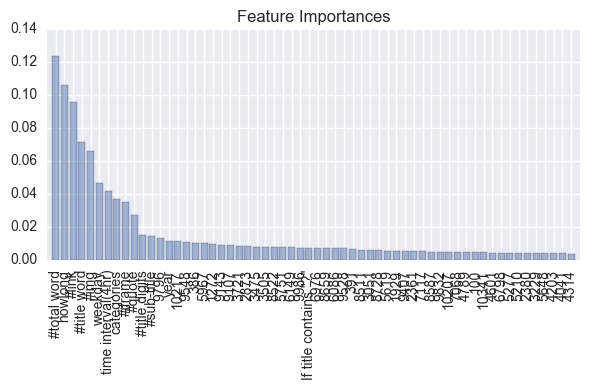

In [12]:
# inline plotting instead of popping out
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

importances = forest.feature_importances_
# get sort indices in descending order
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            X.columns.values[indices[f]], 
                            importances[indices[f]]))

plt.figure()
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align='center',
        alpha=0.5)

plt.xticks(range(X_train.shape[1]), 
           X.columns.values[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()